In [1]:
from zlib import crc32

theory = crc32("Шульгин".lower().encode("utf-8"))%2+1
practice = crc32("Shulgin".lower().encode("utf-8"))%2+1

theory, practice

(1, 2)

**Задание**  
Реализовать пример оптимизации гиперпараметров на небольшой выборке с ошибкой на валидации в качестве функции Q.  
Количество гиперпараметров: не менее 20.  
Рассмотреть алгоритмы: случайный поиск, гауссовый процесс (библиотечная реализация) и:  
1) HOAG;  
2) Жадный алгоритм.

In [27]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm

Определим функцию потерь и функцию качества модели
$$ 
\Large Q(x, \Lambda) = L(x, \Lambda) = \frac{1}{2 n} \|A x - y \|_2^2 + \frac{1}{2} x^\top \Lambda x
$$ 
$\Lambda = \text{diag}(\lambda_1, \dots, \lambda_d)$

In [82]:
def loss(x, A, y, lambd):
    return la.norm(A @ x - y)**2 / (2.0 * A.shape[0]) + x.T @ lambd @ x / 2.0

In [79]:
seed = 1
np.random.seed(seed)

n, d = 100, 20
A = np.random.normal(size=(n, d))
y = np.random.normal(size=n)
lambd_0 = np.diag(np.random.rand(d)) # Hyperparameters

A_train, A_test, y_train, y_test = train_test_split(A, y, random_state=seed)

x_0 = np.random.normal(size=d)

# Greedy optimization

$$
\Large \nabla L(x, \Lambda) = A^\top (A x - y) / n + \Lambda x \\
\Large \nabla_{\Lambda} Q(x, \Lambda) = x \circ x / 2
$$

In [83]:
def grad_L(x, A, y, lambd, indxs):
    return A[indxs].T @ (A[indxs] @ x - y[indxs]) / len(indxs) + lambd @ x

In [84]:
def grad_Q(x):
    return x**2 / 2

$$
\begin{align*}
\Large
\Lambda_+ =& \Large \Lambda - \beta_{\Lambda} \nabla_{\Lambda} Q(T(x, \Lambda), \Lambda) \\
\Large =& \Large \Lambda - \beta_{\Lambda} \nabla_{\Lambda} Q(x - \beta \nabla L(x, \Lambda), \Lambda) \\
\Large =& \Large \Lambda - \beta_{\Lambda} \nabla_{\Lambda} Q(x - \beta \nabla L(x, \Lambda), \Lambda)
\end{align*}
$$

In [266]:
def greedy_opt(A, y, lambd, x_0, lr=1e-2, lr_L=1e-2, seed=1, 
               batch_size=1, epsilon=1e-4, max_iter=100):
    np.random.seed(seed)

    n = A.shape[0]
    x = x_0
    
    x_history = [x_0]
    lambdas = [lambd]
    
    iter_num = 0
 
    for iter_num in tqdm(range(max_iter)):
        indxs = np.random.choice(n, size=batch_size, replace=True)
        x = x - lr_L * grad_L(x, A, y, lambd, indxs)
        lambd = np.maximum(lambd - np.diag(lr * grad_Q(x)), .0) # To make sure that \Lambda_i ≥ 0
        
        x_history.append(x.copy())
        lambdas.append(lambd.copy())

    return x_history, lambdas

In [267]:
x_history, lambdas = greedy_opt(A_train, y_train, lambd_0, x_0, max_iter=500, seed=seed)

100%|██████████| 500/500 [00:00<00:00, 7560.98it/s]


Построим гарфик значений функции качества модели.

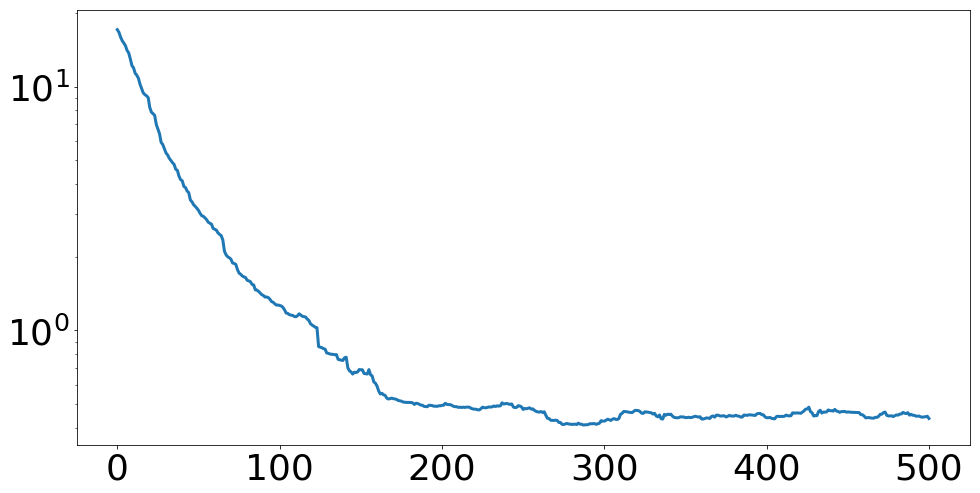

In [268]:
plt.semilogy([loss(x, A, y, lambd) for x, lambd in zip(x_history, lambdas)]);

In [300]:
greedy_min = min([loss(x, A, y, lambd) for x, lambd in zip(x_history, lambdas)])

# Random Search

Реализуем обучение модели с помощью SGD. Соответственно значение оптимизируемой функции будет равно 

In [191]:
def model_fit(A, y, lambd, x_0, lr=1e-2, batch_size=1, max_iter=100, seed=1):
    n = A.shape[0]
    x = x_0
    
    x_history = [x_0]
    iter_num = 0
    
    for iter_num in range(max_iter):
        indxs = np.random.choice(n, size=batch_size, replace=True)
        x = x - lr * grad_L(x, A, y, lambd, indxs)
        x_history.append(x.copy())
        
    return x_history, x

Проверим, что метод работает, и модель действительно обучается.

In [358]:
history, _ = model_fit(A, y, lambd, x_0, max_iter=300)

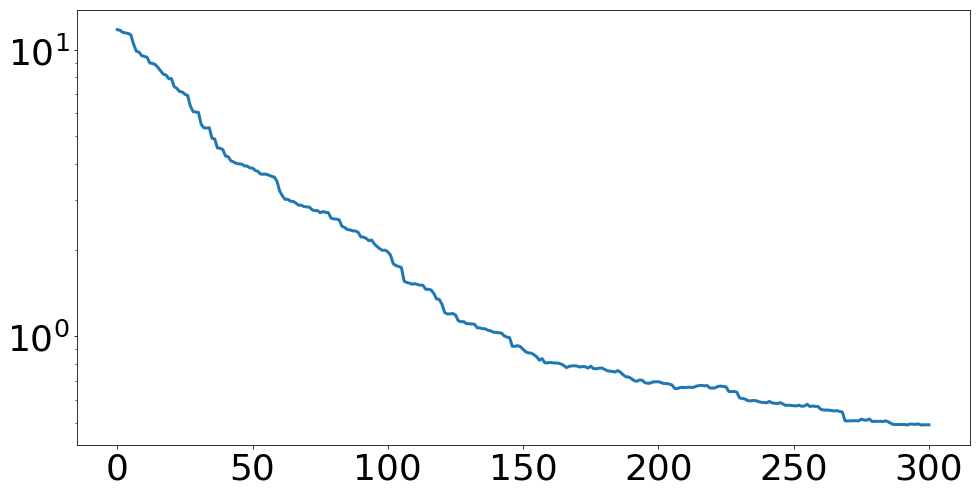

In [359]:
plt.semilogy([loss(x, A, y, lambd) for x in history]);

In [360]:
def random_search(A, y, lambd, x_0, max_iter=100, seed=1, *args):
    A_train, A_test, y_train, y_test = train_test_split(A, y, random_state=seed)
    
    d = A.shape[1]
    x = x_0
    x_history = []
    
    lambdas = []
    best_lambda = lambd
    
    best_loss = loss(x_0, A, y, lambd)
    losses = []
    
    for i in tqdm(range(max_iter)):
        _, x_opt = model_fit(A_train, y_train, lambd, x_0, batch_size=1, max_iter=300, *args)
        losses.append(loss(x_opt, A_test, y_test, lambd))
        
        if losses[-1] < best_loss:
            best_lambda = lambd
            
        lambd = np.diag(np.random.rand(d))
        lambdas.append(lambd.copy())
        x_history.append(x_opt.copy())
    
    return x_history, lambdas, best_lambda, losses

In [361]:
x_history_rs, lambdas_rs, best_lambda, losses = random_search(A, y, lambd, x_0, max_iter=300)

100%|██████████| 300/300 [00:04<00:00, 61.27it/s]


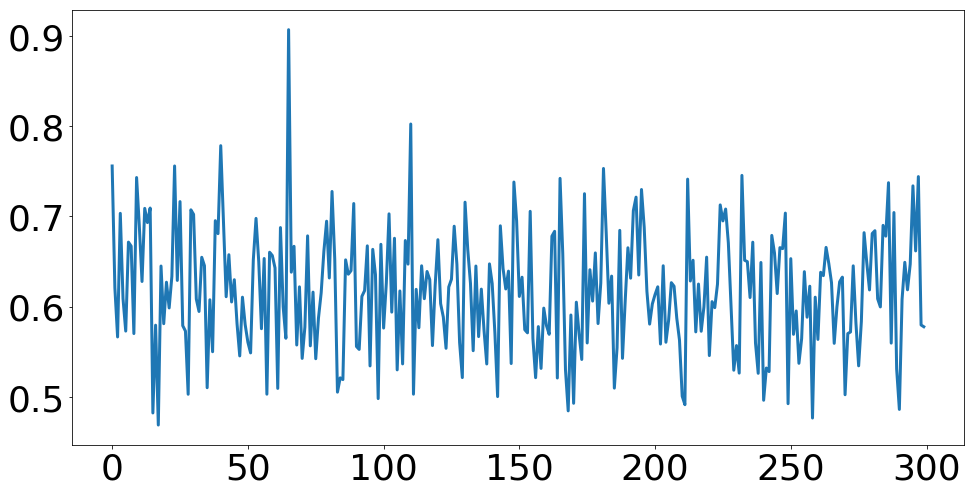

In [362]:
plt.plot(losses);

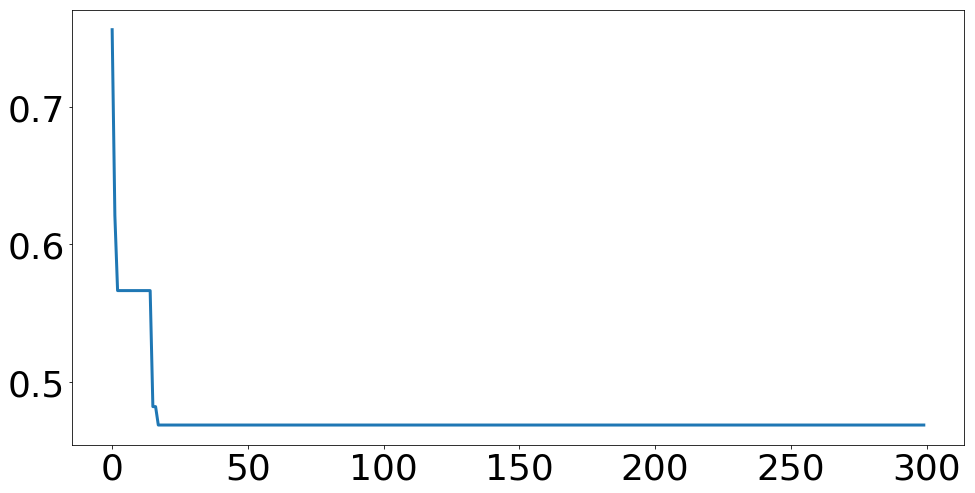

In [363]:
plt.plot([min(losses[:i+1]) for i in range(len(losses))]);

In [364]:
rs_min = min(losses)

# Gaussian Process  
(https://github.com/fmfn/BayesianOptimization)

In [299]:
from bayes_opt import BayesianOptimization

In [367]:
def black_box_function(lambd_0, lambd_1, lambd_2, lambd_3, lambd_4, lambd_5, lambd_6, lambd_7, lambd_8, lambd_9, 
                       lambd_10, lambd_11, lambd_12, lambd_13, lambd_14, lambd_15, lambd_16, lambd_17, lambd_18, lambd_19):
    lambd = np.diag([lambd_0, lambd_1, lambd_2, lambd_3, lambd_4, lambd_5, lambd_6, lambd_7, lambd_8, lambd_9, 
                     lambd_10, lambd_11, lambd_12, lambd_13, lambd_14, lambd_15, lambd_16, lambd_17, lambd_18, lambd_19])
    _, x_opt = model_fit(A_train, y_train, lambd, x_0, batch_size=1, max_iter=300)
    return -loss(x_opt, A_test, y_test, lambd)

In [368]:
# Bounded region of parameter space
pbounds = {"lambd_0": (0, 1), "lambd_1": (0, 1), "lambd_2": (0, 1), "lambd_3": (0, 1), "lambd_4": (0, 1), "lambd_5": (0, 1), 
           "lambd_6": (0, 1), "lambd_7": (0, 1), "lambd_8": (0, 1), "lambd_9": (0, 1), "lambd_10": (0, 1), "lambd_11": (0, 1), 
           "lambd_12": (0, 1), "lambd_13": (0, 1), "lambd_14": (0, 1), "lambd_15": (0, 1), "lambd_16": (0, 1), "lambd_17": (0, 1), 
           "lambd_18": (0, 1), "lambd_19": (0, 1)}

In [369]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [370]:
%%time 
optimizer.maximize(
    init_points=2,
    n_iter=10,
)

|   iter    |  target   |  lambd_0  |  lambd_1  | lambd_10  | lambd_11  | lambd_12  | lambd_13  | lambd_14  | lambd_15  | lambd_16  | lambd_17  | lambd_18  | lambd_19  |  lambd_2  |  lambd_3  |  lambd_4  |  lambd_5  |  lambd_6  |  lambd_7  |  lambd_8  |  lambd_9  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.6196   |  0.417    |  0.7203   |  0.000114 |  0.3023   |  0.1468   |  0.09234  |  0.1863   |  0.3456   |  0.3968   |  0.5388   |  0.4192   |  0.6852   |  0.2045   |  0.8781   |  0.02739  |  0.6705   |  0.4173   |  0.5587   |  0.1404   |  0.1981   |
|  2        | -0.5483   |  0.8007   |  0.9683   |  0.3134   |  0.6923   |  0.8764   |  0.8946   |  0.08504  |  0.03905  |  0.1698   |  0.8781   |  0.09835  |  0.4211   |  0.9579   |  0.5332   |  0.6919 

In [372]:
bo_losses = [-res['target'] for res in optimizer.res]

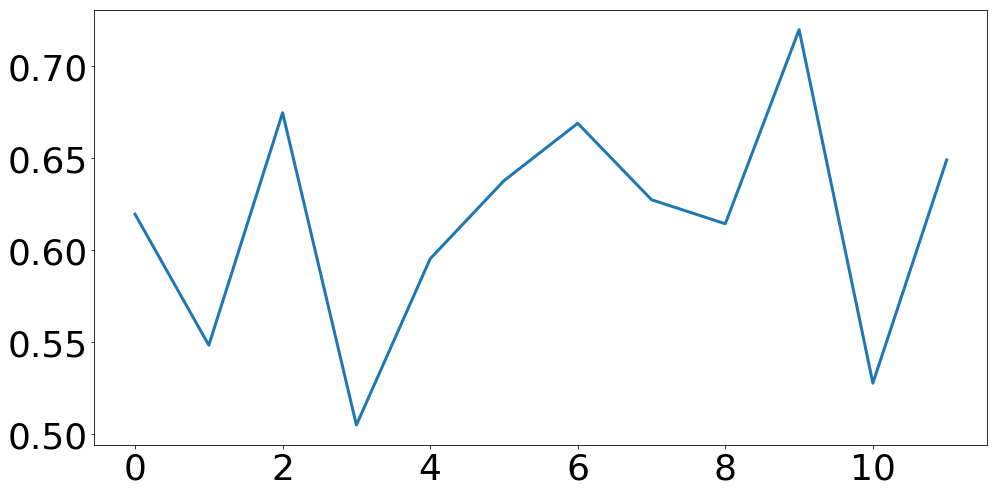

In [373]:
plt.plot(bo_losses);

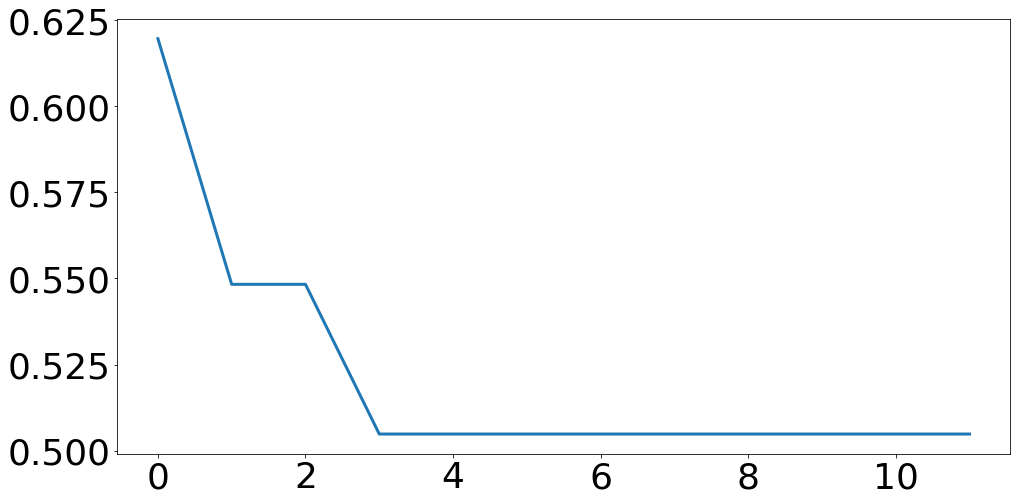

In [374]:
plt.plot([min(bo_losses[:i+1]) for i in range(len(bo_losses))]);

In [375]:
bo_min = min(bo_losses)

In [376]:
pd.DataFrame({'Greedy Opt': [greedy_min], 'Random Search': [rs_min], 'Gaussian Process': [bo_min]}, index=["Minimum value"])

,Greedy Opt,Random Search,Gaussian Process
Minimum value,0.40948,0.468658,0.504863


# Вывод
На данном примере получилось, что жадная оптимизация показала налучшие результаты. Это в общем-то неудивительно, потому что я пользовался аналитическим выражением для градиента функции качества модели.